In [1]:
from pydrake.all import StartMeshcat

meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [12]:
# Import some basic libraries and functions for this tutorial.
import numpy as np
import os

from pydrake.common import temp_directory
from pydrake.geometry import SceneGraphConfig, StartMeshcat
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import AddDefaultVisualization, ModelVisualizer
from pydrake.examples import QuadrotorPlant

from IPython.display import SVG, display
import pydot

In [3]:
def xyz_rpy_deg(xyz, rpy_deg):
    """Shorthand for defining a pose."""
    rpy_deg = np.asarray(rpy_deg)
    return RigidTransform(RollPitchYaw(rpy_deg * np.pi / 180), xyz)

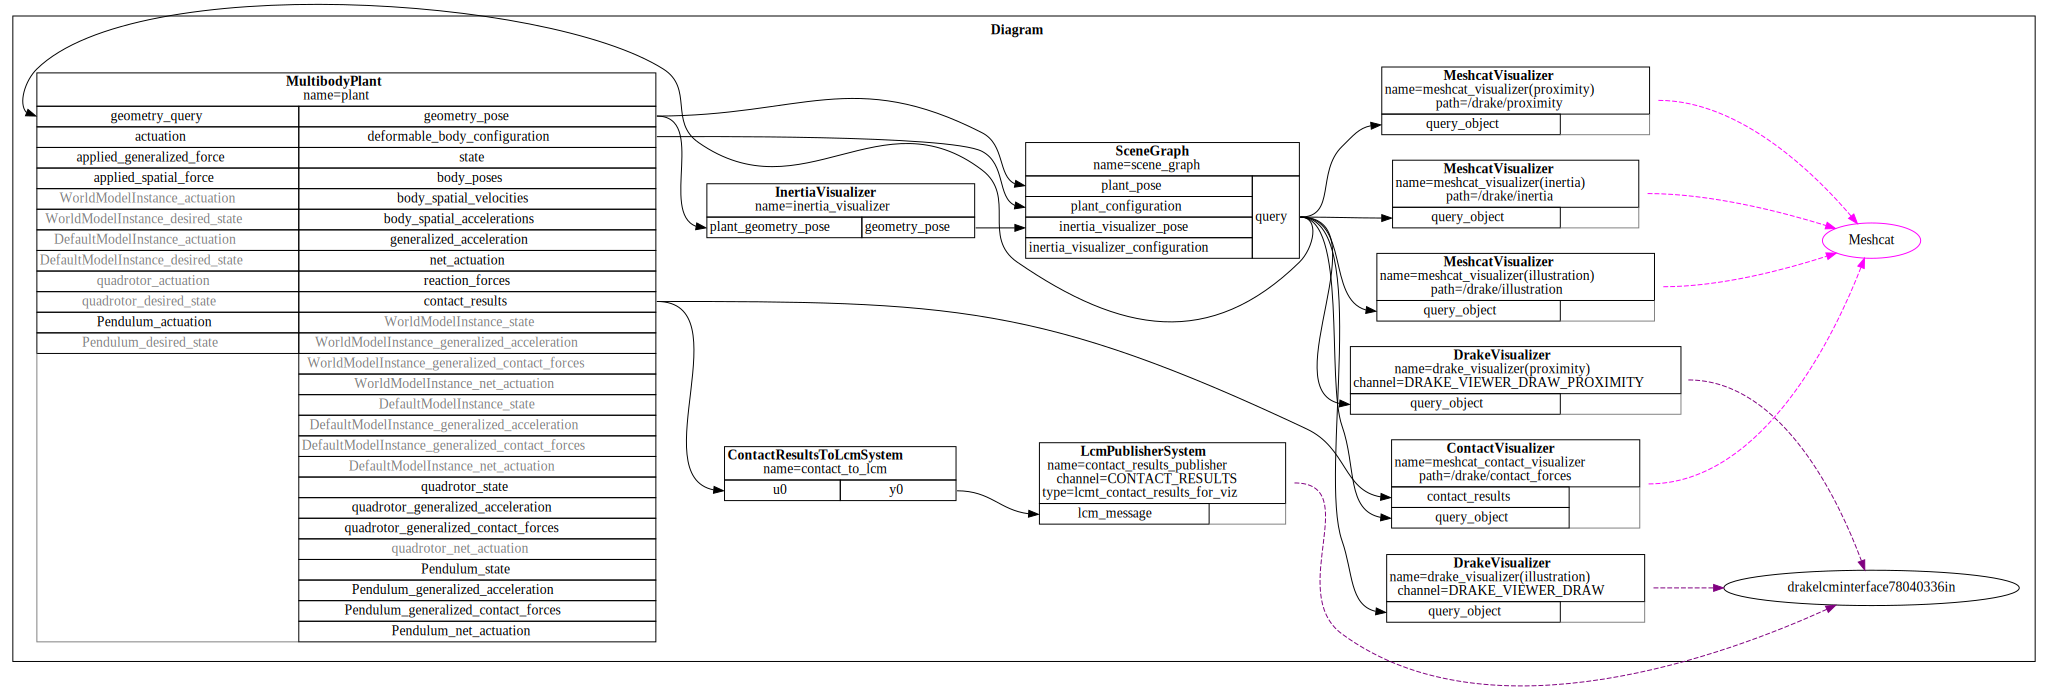

In [13]:
# First we'll choose one of Drake's example model files, a KUKA iiwa arm.
skydio = (
    "package://drake_models/skydio_2/quadrotor.urdf")
pendulum = (
    "res/Pendulum.urdf"
)

meshcat.Delete()
# meshcat.DeleteAddedControls()

builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(
    builder, time_step=0.0005)
parser = Parser(plant)

# # Create a model visualizer and add the robot arm.
# # visualizer = ModelVisualizer(meshcat=meshcat)
parser.AddModels(url=skydio)
parser.AddModels(pendulum)

pendulum_base_frame = plant.GetFrameByName("base")
quadrotor_base_link = plant.GetFrameByName("base_link")
# # plant.WeldFrames(plant.world_frame(), quadrotor_base_link)
plant.WeldFrames(quadrotor_base_link, pendulum_base_frame, X_FM=xyz_rpy_deg([0, 0, 0.03], [0, 180, 0]),)
# # plant.WeldFrames(plant.world_frame(), pendulum_base_frame, X_FM=xyz_rpy_deg([0, 0, 0], [0, 180, 0]),)
# plant.WeldFrames(quadrotor_base_link, pendulum_base_frame)
plant.Finalize()

quadrotor_body = plant.GetBodyByName("base_link")
plant.SetDefaultFreeBodyPose(quadrotor_body, xyz_rpy_deg([0, 0, 0.5], [0, 0, 0]))

# Add visualization to see the geometries.
AddDefaultVisualization(builder=builder, meshcat=meshcat)

# Start the interactive visualizer.
# Click the "Stop Running" button in MeshCat when you're finished.
diagram = builder.Build()
simulator = Simulator(diagram)

simulator.Initialize()
simulator.set_target_realtime_rate(1.)

plant_context = diagram.GetMutableSubsystemContext(
    plant, simulator.get_mutable_context())

plant.SetFreeBodyPose(plant_context, quadrotor_body, xyz_rpy_deg([0, 0, 0.5], [0, 0, 0]))

display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

simulator.AdvanceTo(10.0)

# print(plant.get_state_output_port())
# print(plant.get_actuation_input_port())

In [75]:
print(dir(plant))

['Accept', 'AddBallConstraint', 'AddCouplerConstraint', 'AddDistanceConstraint', 'AddForceElement', 'AddFrame', 'AddJoint', 'AddJointActuator', 'AddModelInstance', 'AddRigidBody', 'AddWeldConstraint', 'AllocateContext', 'AllocateDiscreteVariables', 'AllocateImplicitTimeDerivativesResidual', 'AllocateInputAbstract', 'AllocateInputVector', 'AllocateOutput', 'AllocateTimeDerivatives', 'CalcBiasCenterOfMassTranslationalAcceleration', 'CalcBiasSpatialAcceleration', 'CalcBiasTerm', 'CalcBiasTranslationalAcceleration', 'CalcCenterOfMassPositionInWorld', 'CalcCenterOfMassTranslationalAccelerationInWorld', 'CalcCenterOfMassTranslationalVelocityInWorld', 'CalcConservativePower', 'CalcForceElementsContribution', 'CalcForcedDiscreteVariableUpdate', 'CalcForcedUnrestrictedUpdate', 'CalcGeneralizedForces', 'CalcGravityGeneralizedForces', 'CalcImplicitTimeDerivativesResidual', 'CalcInverseDynamics', 'CalcJacobianAngularVelocity', 'CalcJacobianCenterOfMassTranslationalVelocity', 'CalcJacobianPositionV

In [20]:
print(dir(plant.get_input_port(0)))
print(plant.get_input_port(9).size())
print(plant.GetVelocityNames())

['Allocate', 'Eval', 'EvalAbstract', 'EvalBasicVector', 'FixValue', 'GetFullDescription', 'HasValue', '__class__', '__del__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_pybind11_del_orig', 'get_data_type', 'get_index', 'get_name', 'get_system', 'size', 'ticket']
0
['quadrotor_base_link_wx', 'quadrotor_base_link_wy', 'quadrotor_base_link_wz', 'quadrotor_base_link_vx', 'quadrotor_base_link_vy', 'quadrotor_base_link_vz', 'Pendulum_theta_w']
